In [1]:
##Importing necessary libraries
import pandas as pd
from dataprep import *
import datetime
from stockdata import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate

import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
from sklearn.model_selection import train_test_split


In [1]:
import tensorflow as tf 

# Get the list of available GPUs 
gpus = tf.config.experimental.list_physical_devices('GPU') 

# Print the list of available GPUs 
print(gpus)

[]


In [2]:
#Data acquisition
ticker='CENTRALBK.NS'
stock_data=StockData(ticker)
stock_dates=stock_data.iloc[:,0]
stock_data.reset_index(inplace=True)


[*********************100%***********************]  1 of 1 completed


c:\Users\vysha\OneDrive\Desktop\STOCKFORECAST\main\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\vysha\OneDrive\Desktop\STOCKFORECAST\main\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [3]:
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'],
                open=stock_data['Open'],
                high=stock_data['High'],
                low=stock_data['Low'],
                close=stock_data['Close']),])

fig.update_layout(xaxis_rangeslider_visible=False)
plt.savefig('tickerpic.png')
fig.show()



<Figure size 640x480 with 0 Axes>

In [4]:

X_train,X_test,y_train,y_test=train_test_split(stock_data.drop(columns=['Date','Close']),stock_data['Close'],test_size=0.2,shuffle=False)
##print(test_price)

print("X_train.....X_test",X_train.shape,y_train.shape,X_test.shape,y_test.shape)

min_max = MinMaxScaler(feature_range=(0, 1))
close_price=MinMaxScaler(feature_range=(0,1))

X_train_scaled=min_max.fit_transform(X_train)
X_test_scaled=min_max.transform(X_test)
close_price.fit(stock_data['Close'].values.reshape(-1,1))
y_train_scaled=close_price.transform(y_train.values.reshape(-1,1))
y_test_scaled=close_price.transform(y_test.values.reshape(-1,1))
print(X_train_scaled.shape,X_test_scaled.shape)
print(y_train_scaled.shape,y_test_scaled.shape)
v=X_test_scaled.shape[0]


X_train.....X_test (3124, 33) (3124,) (781, 33) (781,)
(3124, 33) (781, 33)
(3124, 1) (781, 1)


In [5]:
X_train_scaled

array([[0.49260638, 0.50642746, 0.44811257, ..., 0.29825506, 0.54402347,
        0.42494188],
       [0.44477483, 0.45144453, 0.44833176, ..., 0.29825506, 0.5062554 ,
        0.44586239],
       [0.44203561, 0.46439418, 0.45424954, ..., 0.29825506, 0.49879413,
        0.45302221],
       ...,
       [0.02427625, 0.02146315, 0.02602454, ..., 0.00820944, 0.00777016,
        0.00969232],
       [0.02823972, 0.0219623 , 0.02808589, ..., 0.00908822, 0.00845589,
        0.01078124],
       [0.0250194 , 0.01771958, 0.02525153, ..., 0.00993114, 0.00917161,
        0.0117622 ]])

In [6]:
# Define the number of time steps
time_steps = 60

X_train_copy=X_train.copy()
y_train_copy=y_train.copy()

X_train=[]
y_train=[]
X_test=[]

# Loop through the data to create partitions
for i in range(time_steps, X_train_scaled.shape[0]):
    # Create a partition of the previous 60 days' data
    X_train.append(X_train_scaled[i - time_steps:i,:])

    # Append the next day's Close price to the label array
'''for i in range(time_steps, X_train_scaled.shape[0]-15):
    y_train.append(y_train_scaled[i+15, 0])'''
X_train, y_train = np.array(X_train), np.array(y_train)
for i in range(time_steps, X_train_scaled.shape[0]-15):
    y_train=np.insert(y_train,i-time_steps,y_train_scaled[i+15])
x=y_test_scaled[:16]
for i in range(0,15):
    y_train=np.insert(y_train,i,x[i])
X_test_scaled=X_test_scaled.tolist()
a= X_train_scaled[-60:].tolist()
X_test_scaled= a + X_test_scaled
X_test_scaled=np.array(X_test_scaled)
'''for i in range(0,58):
    X_test_scaled=np.insert(X_test_scaled,i,a[i,:])'''

# Loop through the data to create partitions
for i in range(time_steps, X_test_scaled.shape[0]):
    # Create a partition of the previous 60 days' data
    X_test.append(X_test_scaled[i - time_steps:i,:])

    # Append the next day's Close price to the label array

X_test = np.array(X_test)
X_train =np.array(X_train)
y_train= np.array(y_train)
y_train=y_train.astype(np.float32)
print(X_train.shape, y_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 33))

print(len(X_train),len(y_train))

print(y_train)

(3064, 60, 33) (3064,)
3064 3064
[0.02287607 0.02185936 0.02236772 ... 0.02745129 0.02770546 0.02465532]


In [7]:
y_test.shape

(781,)

In [8]:
model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 33)))
model1.add(Dropout(0.2))

model1.add(LSTM(units=50,return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(units=50,return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(units=50,return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(units=50))
model1.add(Dropout(0.2))


model1.add(Dense(units=1))



In [9]:
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 33)))
model2.add(Dropout(0.1))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=50))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 60, 50)            16800     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [10]:
# Compile and train the model
model1.compile(optimizer='adam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
96/96 [==============================] - 17s 97ms/step - loss: 0.0131
Epoch 2/10
96/96 [==============================] - 9s 90ms/step - loss: 0.0041
Epoch 3/10
96/96 [==============================] - 8s 82ms/step - loss: 0.0039
Epoch 4/10
96/96 [==============================] - 8s 84ms/step - loss: 0.0037
Epoch 5/10
96/96 [==============================] - 10s 107ms/step - loss: 0.0030
Epoch 6/10
96/96 [==============================] - 9s 91ms/step - loss: 0.0031
Epoch 7/10
96/96 [==============================] - 8s 87ms/step - loss: 0.0027
Epoch 8/10
96/96 [==============================] - 8s 86ms/step - loss: 0.0028
Epoch 9/10
96/96 [==============================] - 9s 97ms/step - loss: 0.0022
Epoch 10/10
96/96 [==============================] - 9s 95ms/step - loss: 0.0023


In [11]:
model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=22)


Epoch 1/10
140/140 [==============================] - 13s 58ms/step - loss: 0.0057
Epoch 2/10
140/140 [==============================] - 6s 45ms/step - loss: 0.0029
Epoch 3/10
140/140 [==============================] - 6s 42ms/step - loss: 0.0022
Epoch 4/10
140/140 [==============================] - 6s 42ms/step - loss: 0.0024
Epoch 5/10
140/140 [==============================] - 6s 42ms/step - loss: 0.0024
Epoch 6/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0018
Epoch 7/10
140/140 [==============================] - 6s 45ms/step - loss: 0.0015
Epoch 8/10
140/140 [==============================] - 6s 42ms/step - loss: 0.0021
Epoch 9/10
140/140 [==============================] - 6s 46ms/step - loss: 0.0013
Epoch 10/10
140/140 [==============================] - 7s 48ms/step - loss: 0.0012


In [12]:
ensemble_model = concatenate([model1.output, model2.output])
ensemble_outputs = Dense(units=1)(ensemble_model)

final_model = Model(inputs=[model1.input, model2.input], outputs=ensemble_outputs)


In [13]:
final_model.compile(optimizer='adam', loss='mean_squared_error')
history_ensemble = final_model.fit([X_train, X_train], y_train, epochs=10, batch_size=32)


Epoch 1/10
96/96 [==============================] - 23s 108ms/step - loss: 0.0051
Epoch 2/10
96/96 [==============================] - 11s 116ms/step - loss: 0.0012
Epoch 3/10
96/96 [==============================] - 10s 101ms/step - loss: 0.0011
Epoch 4/10
96/96 [==============================] - 11s 119ms/step - loss: 0.0014
Epoch 5/10
96/96 [==============================] - 12s 121ms/step - loss: 0.0011
Epoch 6/10
96/96 [==============================] - 12s 128ms/step - loss: 0.0011
Epoch 7/10
96/96 [==============================] - 11s 110ms/step - loss: 9.5046e-04
Epoch 8/10
96/96 [==============================] - 11s 117ms/step - loss: 8.9884e-04
Epoch 9/10
96/96 [==============================] - 12s 123ms/step - loss: 9.0460e-04
Epoch 10/10
96/96 [==============================] - 11s 118ms/step - loss: 7.2271e-04


In [14]:
close_price=MinMaxScaler(feature_range=(0,1))


test_price = y_test_scaled



In [15]:
dataset_total = stock_data.drop(columns=['Date','Close'])
##print(dataset_total.head)
inputs = dataset_total[len(dataset_total) - len(test_price) - 60:]
print(len(dataset_total) - len(test_price))
inputs=np.array(inputs)
inputs = inputs.reshape(-1, 33)
print(inputs.shape)
inputs = min_max.transform(inputs)
X_tes = []
for i in range(60,76):
    X_tes.append(inputs[i - 60:i, :])
X_tes = np.array(X_tes)
print(X_tes.shape)

predicted_stock_price = final_model.predict([X_tes,X_tes])
print(predicted_stock_price)


close_price.fit(stock_data['Close'].values.reshape(-1,1))

predicted_stock_price = close_price.inverse_transform(predicted_stock_price.reshape(-1,1))
print(predicted_stock_price)
print(y_test[60:76])
print(len(inputs))

3124
(841, 33)
(16, 60, 33)


c:\Users\vysha\OneDrive\Desktop\STOCKFORECAST\main\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 3s 3s/step
[[0.0157348 ]
 [0.0153443 ]
 [0.01487686]
 [0.01492544]
 [0.01584841]
 [0.01714866]
 [0.01831953]
 [0.02099106]
 [0.02443729]
 [0.02785327]
 [0.02853107]
 [0.02662959]
 [0.02426293]
 [0.0228119 ]
 [0.02211563]
 [0.02154128]]
[[13.295225]
 [13.218409]
 [13.126457]
 [13.136015]
 [13.317573]
 [13.573348]
 [13.803673]
 [14.329194]
 [15.007111]
 [15.679075]
 [15.812406]
 [15.438362]
 [14.972811]
 [14.687376]
 [14.55041 ]
 [14.437428]]
3184    17.500000
3185    18.500000
3186    17.950001
3187    17.700001
3188    17.549999
3189    17.500000
3190    17.299999
3191    17.549999
3192    17.850000
3193    18.150000
3194    18.200001
3195    17.950001
3196    17.650000
3197    17.600000
3198    17.700001
3199    17.900000
Name: Close, dtype: float64
841


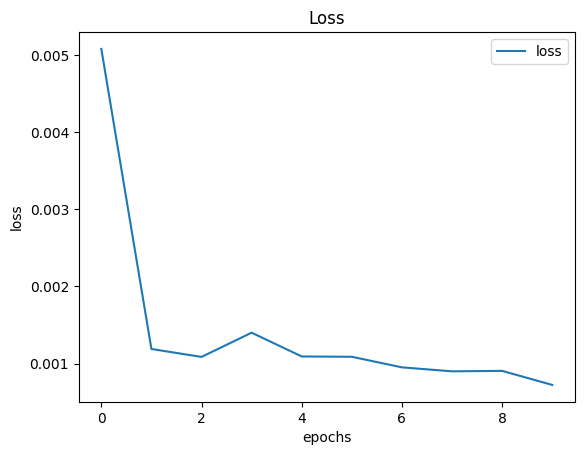

In [16]:
history_df = pd.DataFrame(history_ensemble.history)
p=history_df.loc[:, ['loss']].plot()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss')
plt.savefig('loss.png')
plt.show()

25/25 [==============================] - 1s 31ms/step


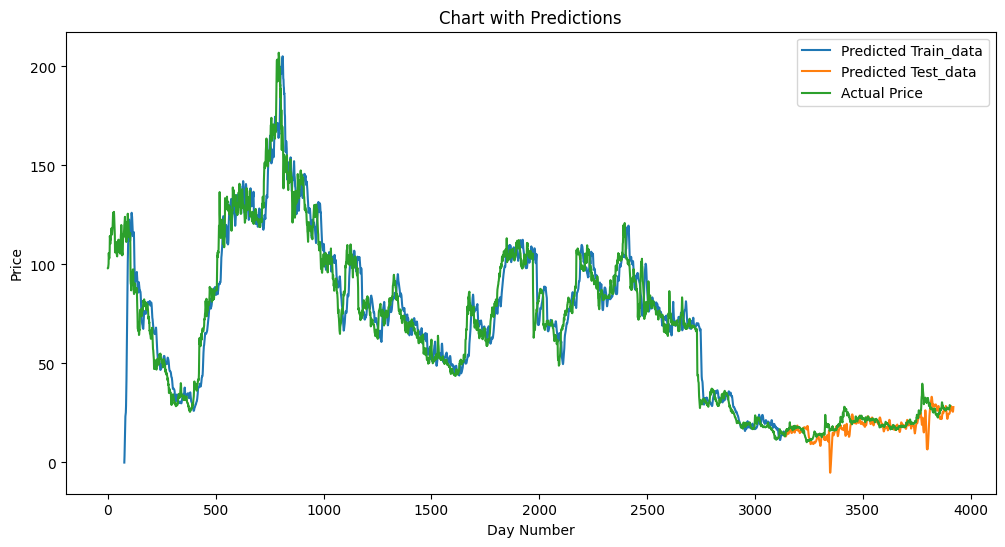

In [17]:
m=final_model.predict([X_train,X_train])
n=final_model.predict([X_test,X_test])
a=[]
b=[]
c=[]
for i in range(76,76+len(X_train)):
    a.append(i)
for i in range(76+len(X_train),76+len(X_train)+len(X_test)):
    b.append(i)
#stock_data.drop(columns=['Date','Close'])
plt.figure(figsize=(12,6))
plt.plot(a,close_price.inverse_transform(m.reshape(-1,1)))
plt.plot(b,close_price.inverse_transform(n.reshape(-1,1)))
l=stock_data.loc[: , 'Close']
for i in range(0,len(l)):
    c.append(i)
plt.plot(c,l)
plt.ylabel('Price')
plt.xlabel('Day Number')
plt.title('Chart with Predictions')
plt.legend(['Predicted Train_data', 'Predicted Test_data','Actual Price'])

plt.savefig('Chart with predictions.png')
plt.show()

1/1 [==============================] - 0s 41ms/step


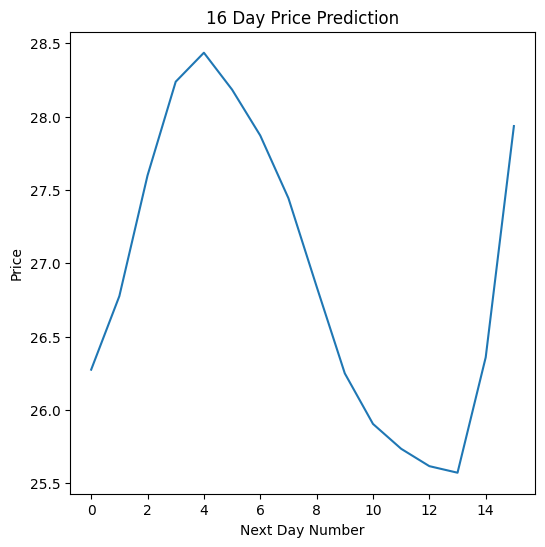

In [18]:

w=final_model.predict([X_test[-16:],X_test[-16:]])
plt.figure(figsize=(6,6))

plt.plot(close_price.inverse_transform(w.reshape(-1,1)))
plt.ylabel('Price')
plt.xlabel('Next Day Number')
plt.title('16 Day Price Prediction')
plt.savefig('16 Day Price Prediction.png')
plt.show()